## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [2]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [4]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location,even_odd_correlation
from plts import plot_raster_with_tuning_curve,plot_feature_arrow,plot_pca_scatter,plot_feature_color_bars
sys.path.append('../scripts')
from settings import PATHS, METHODS,EXCLUSION,INCREMENT
from pldm_settings import PLOT_PARAMS,SI_THRESHOLD,ALPHA,FEATURE_COLORS








In [5]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [6]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [7]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [8]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [9]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_23494/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [10]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [11]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [12]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


In [13]:
all_results

,unit_ind,session_id,label,spike_name,place_bins,spike_position,trial_changes,trial_Num,trial_place_bins,place_sem,...,place_fr_anova_surr_p_val,place_fr_anova_surr_z_score,place_fr_info_surr_p_val,place_fr_info_surr_z_score,is_place_anova,is_place_info,is_place_fr_anova,is_place_fr_info,channel,sessions
0,0,EU001_0_train_events.mat,3ldmicro2,['NSX098_1'],"[11.097516632672882, 11.143666364113184, 11.18...","[nan, nan, nan, nan, nan, 0.01982426470588236,...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[16.666666666666668, 15.266814761524644, 13.3...","[0.45015454524323173, 0.35786746381625456, 0.3...",...,0.908,-1.232867,0.921,-1.307244,False,False,False,False,98,EU001_0
1,1,EU001_0_train_events.mat,3ldmicro2,['NSX098_2'],"[0.48277980699855716, 0.5650605102830095, 0.64...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 7.587753533886536e-...","[0.0848389902899717, 0.07202675923901641, 0.07...",...,0.917,-1.365193,0.892,-1.206590,False,False,False,False,98,EU001_0
2,2,EU001_0_train_events.mat,3ldmicro3,['NSX099_1'],"[1.1842697233322237, 1.1720035563490543, 1.168...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 3.707393238536612e-06, 0...","[0.1321844774316897, 0.11195476677117569, 0.10...",...,0.772,-0.775108,0.832,-0.953273,False,False,False,False,99,EU001_0
3,3,EU001_0_train_events.mat,3ldmicro3,['NSX099_2'],"[0.2137445887445888, 0.3147921362445991, 0.413...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.1282067726497952, 0.10573047143648222, 0.10...",...,0.494,-0.052684,0.785,-0.796140,False,False,False,False,99,EU001_0
4,4,EU001_0_train_events.mat,3ldmicro4,['NSX100_1'],"[6.5327788530913535, 6.660508627001465, 6.6718...","[nan, nan, nan, nan, nan, 0.01982426470588236,...","[90, 213, 349, 431, 578, 651, 784, 894, 1049, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[5.000000000000001, 5.377211596667435, 5.3477...","[0.47385927608353245, 0.35978170458897846, 0.3...",...,0.013,2.616979,0.026,2.235433,True,True,True,True,100,EU001_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,6,R1391T_0_train_events.mat,LB3,['NSX007_3'],"[0.860953282828283, 0.814623593592706, 0.70180...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[143, 322, 449, 582, 720, 806, 929, 1103, 1223...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.4549007440085697, 0.36531775648203685, 0.25...",...,0.412,0.147544,0.628,-0.431253,False,False,False,False,7,R1391T_0
386,0,R1414E_0_train_events.mat,3Ldmicro8,['NSX104_1'],"[6.895523313492065, 6.968529031072344, 7.06119...","[nan, nan, nan, nan, nan, nan, nan, nan, 0.042...","[142, 315, 458, 630, 752, 837, 919, 1029, 1146...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[7.142857142857143, 7.327544539679706, 6.9165...","[0.365760920546466, 0.3282870963799351, 0.3385...",...,0.327,0.346138,0.350,0.292491,False,False,False,False,104,R1414E_0
387,0,R1414E_1_train_events.mat,3Ldmicro8,['NSX104_1'],"[13.79444557178932, 14.112764445510411, 14.686...","[nan, nan, nan, nan, 0.011989999999999997, 0.0...","[115, 247, 362, 497, 694, 769, 891, 1017, 1149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[17.142857142857146, 13.873296509249924, 9.68...","[0.5776646084065195, 0.42601769035660875, 0.37...",...,0.029,2.020694,0.022,2.199174,False,False,True,True,104,R1414E_1
388,1,R1414E_1_train_events.mat,3Ldmicro8,['NSX104_2'],"[10.084128111471863, 9.967601988121892, 9.7421...","[nan, nan, nan, nan, 0.

In [14]:
# Display the original dataframe before filtering
print("Original dataframe shape:", all_results.shape)
print(all_results.columns)
all_results['firing_rate'] = all_results['fr_bins'].apply(lambda x: np.mean(x))
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))
# Create a filtered copy
results = deepcopy(all_results)

results = results[results['firing_rate'].astype(float) < EXCLUSION['RATE_MAX']]
results = results[results['firing_rate'].astype(float) > EXCLUSION['RATE_MIN']]
results = results[results['presence_ratio'].astype(float) > EXCLUSION['TOTAL_PRESENCE_RATIO']]
# Display the filtered dataframe
print("\nFiltered dataframe shape:", results.shape)

Original dataframe shape: (390, 32)
Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions'],
      dtype='object')

Filtered dataframe shape: (306, 34)


## Get Features 

In [15]:
## Peak Rate
results['peak_rate'] = results['fr_bins'].apply(np.max)

## Average Rate
results['average_rate'] = results['fr_bins'].apply(np.mean)

## SNR
results['peak_over_average_rate '] = results['peak_rate'] / results['average_rate']

## Place Field
place_field_results = results['fr_bins'].apply(lambda x: find_place_field(x))
results['place_field_width'] = place_field_results.apply(lambda x: x[0])
results['noise_bins'] = place_field_results.apply(lambda x: x[1])
results['labeled_fields'] = place_field_results.apply(lambda x: x[2])
results['N_place_fields'] = place_field_results.apply(lambda x: x[3])
results['place_field_peak_location'] = place_field_results.apply(lambda x: x[4])

## Trial Peak Location
trial_peak_results = results.apply(lambda row: find_place_location(row['trial_fr'], row['place_field_peak_location']), axis=1)
results['trial_peak_loc'] = trial_peak_results.apply(lambda x: x[0])
results['trial_peak_rate'] = trial_peak_results.apply(lambda x: x[1])
results['num_trials_close_to_peak'] = trial_peak_results.apply(lambda x: x[2])
results['place_field_consistency'] = trial_peak_results.apply(lambda x: x[3])

## Presence Ratio
results['presence_ratio'] = results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

## Even Odd Correlation
results['even_odd_correlation'] = results.apply(lambda row: even_odd_correlation(row['trial_fr']), axis=1)

In [16]:
# ## Compute Features
# # Initialize new columns with appropriate data types
# all_results['peak_rate'] = np.nan
# all_results['average_rate'] = np.nan
# all_results['SNR'] = np.nan
# all_results['place_field_bins'] = pd.Series([None] * len(all_results))
# all_results['noise_bins'] = pd.Series([None] * len(all_results))
# all_results['labeled_fields'] = pd.Series([None] * len(all_results))
# all_results['N_place_fields'] = pd.Series([None] * len(all_results))
# all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
# all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
# all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
# all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
# all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# # Calculate basic rate features
# all_results['peak_rate'] = all_results['place_bins'].apply(np.max)
# all_results['average_rate'] = all_results['place_bins'].apply(np.mean)
# all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# # Calculate place field features for each unit
# for i in range(len(all_results)):
#     # Forward direction analysis
#     (all_results.at[i,'place_field_bins'], 
#      all_results.at[i,'noise_bins'],
#      all_results.at[i,'labeled_fields'], 
#      all_results.at[i,'N_place_fields'],
#      all_results.at[i,'peak_rate'],
#      all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['place_bins'][i])

#     (all_results.at[i,'trial_peak_loc'],
#      all_results.at[i,'trial_peak_rate'], 
#      all_results.at[i,'num_trials_close_to_peak'],
#      all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_place_bins'][i], 
#                                                                                    all_results['place_field_peak_location'][i],tolerance = 6)



In [17]:
# all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

In [18]:
# print(all_results.columns)
# all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))

# # Create a filtered copy
# all_results = all_results[all_results['firing_rate'].astype(float) < 20]
# all_results = all_results[all_results['firing_rate'].astype(float) > .1]

# # Reset index
# all_results = all_results.reset_index(drop=True)

## Feature Estimation 

In [19]:
peak_rate = results['peak_rate']
average_rate = results['average_rate']
peak_over_average_rate = peak_rate / average_rate
place_field_width = results['place_field_width']
num_place_fields = results['N_place_fields']
place_field_consistency= results['place_field_consistency']
presence_ratio = results['presence_ratio']
even_odd_corr = results['even_odd_correlation']

In [20]:
place_info = results['place_fr_info']
place_anova = results['place_fr_anova']

features_df = pd.DataFrame({
    'Peak Rate': peak_rate,
    'Average Rate': average_rate,
    'Peak Over Average': peak_over_average_rate,
    'Place Field Width': place_field_width,
    'Num Place Fields':num_place_fields,
    'Place Field Consistency': place_field_consistency,
    'Presence Ratio': presence_ratio,
    'Even Odd Correlation': even_odd_corr,
    'place_info': place_info,
    'place_anova': place_anova
}).dropna()

In [21]:
# Drop 'place_info' and 'place_anova' columns for PCA features
features = features_df.drop(['place_info', 'place_anova'], axis=1)

In [23]:
correlations = {}
for feature_name, feature_data in features.items():
    feature_array = np.array(feature_data, dtype=float)
    
    # Calculate correlations, handling NaN values
    for metric_name, metric in [('place_info', features_df['place_info']), ('place_anova', features_df['place_anova'] )]:
        mask = ~np.isnan(feature_array) & ~np.isnan(metric)
        if np.sum(mask) > 0:
            corr = np.corrcoef(feature_array[mask], np.array(metric)[mask])[0,1]
            correlations[f'{feature_name}_vs_{metric_name}'] = corr

# Calculate correlation matrix between features
feature_names = list(features.keys())
n_features = len(feature_names)
correlation_matrix = np.zeros((n_features, n_features))

for i, feat1_name in enumerate(feature_names):
    for j, feat2_name in enumerate(feature_names):
        feat1 = np.array(features[feat1_name], dtype=float)
        feat2 = np.array(features[feat2_name], dtype=float)
        mask = ~np.isnan(feat1) & ~np.isnan(feat2)
        correlation_matrix[i,j] = np.corrcoef(feat1[mask], feat2[mask])[0,1] if np.sum(mask) > 0 else np.nan


In [25]:
place_info = features_df['place_info']
place_anova = features_df['place_anova']











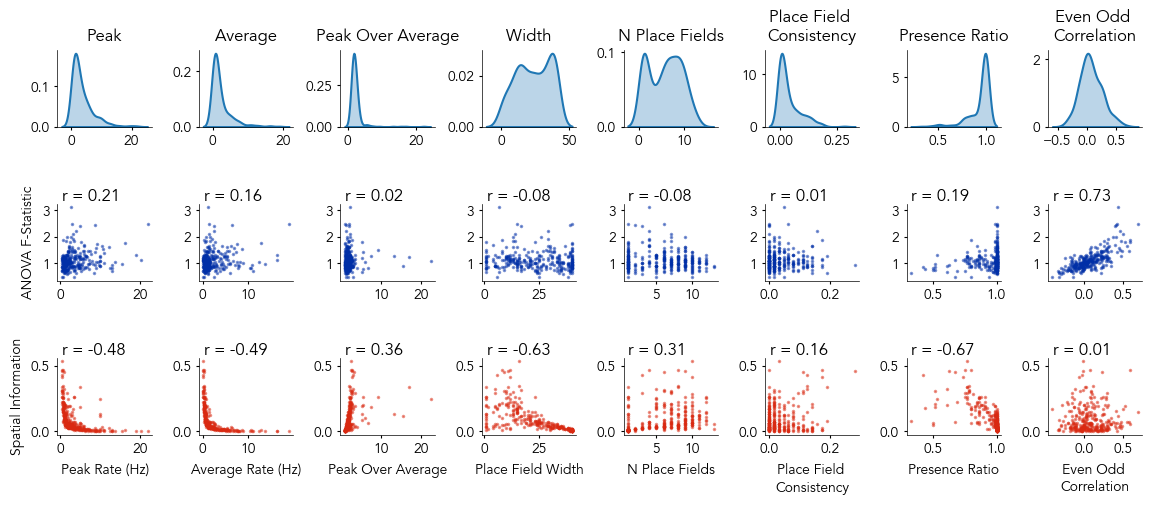

In [26]:
grid = make_grid(3, 8, wspace=.5,hspace = 1,figsize=(14,5)
                 )

plt.rcParams.update(PLOT_PARAMS)
color_map = 'Greys'
anova_color = '#002FA7'  # Deep blue for ANOVA
info_color = '#D92911'   # Deep red for Spatial Info
SNR_color = 'darkred'

# Define variables for scatter plot parameters
s = 1
alpha = 0.5


# Define proper variable names for all features
peak_rate = features['Peak Rate']
average_rate = features['Average Rate']
peak_over_average_rate = features['Peak Over Average']
place_field_width = features['Place Field Width']
num_place_fields = features['Num Place Fields']
place_field_consistency = features['Place Field Consistency']
presence_ratio = features['Presence Ratio']
even_odd_corr = features['Even Odd Correlation']


# Use proper variable names in plotting
ax = get_grid_subplot(grid, 0, 0)
sns.kdeplot(data=peak_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Peak')
ax.set_ylabel('')
ax.set_xlabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 0)
ax.scatter(peak_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Peak Rate_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_ylabel('ANOVA F-Statistic')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 0)
ax.scatter(peak_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Peak Rate_vs_place_info"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
ax.set_ylabel('Spatial Information')
ax.set_xlabel('Peak Rate (Hz)')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 1)
sns.kdeplot(data=average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Average')
ax.set_ylabel('')
ax.set_xlabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 1)
ax.scatter(average_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Average Rate_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 1)
ax.scatter(average_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Average Rate_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Average Rate (Hz)')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 2)
sns.kdeplot(data=peak_over_average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Peak Over Average')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 2)
ax.scatter(peak_over_average_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Peak Over Average_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 2)
ax.scatter(peak_over_average_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Peak Over Average_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_ylabel('')
ax.set_xlabel('Peak Over Average')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 3)
sns.kdeplot(data=place_field_width, alpha=0.3, fill=True, ax=ax)
ax.set_title('Width')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 3)
ax.scatter(place_field_width, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Place Field Width_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 3)
ax.scatter(place_field_width, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Place Field Width_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Place Field Width')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 4)
sns.kdeplot(data=num_place_fields, alpha=0.3, fill=True, ax=ax)
ax.set_title('N Place Fields')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 4)
ax.scatter(num_place_fields, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Num Place Fields_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 4)
ax.scatter(num_place_fields, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Num Place Fields_vs_place_info"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
ax.set_xlabel('N Place Fields')
ax.set_ylabel('')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 5)
sns.kdeplot(data=place_field_consistency, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Place Field \nConsistency')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 5)
ax.scatter(place_field_consistency, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Place Field Consistency_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 5)
ax.scatter(place_field_consistency, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Place Field Consistency_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Place Field \nConsistency')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 6)
sns.kdeplot(data=presence_ratio, alpha=0.3, fill=True, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Presence Ratio')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 6)
ax.scatter(presence_ratio, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Presence Ratio_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 6)
ax.scatter(presence_ratio, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Presence Ratio_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Presence Ratio')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 7)
sns.kdeplot(data=even_odd_corr, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Even Odd \nCorrelation')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 7)
ax.scatter(even_odd_corr, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 1.2, f'r = {correlations["Even Odd Correlation_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 7)
ax.scatter(even_odd_corr, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 1.2, f'r = {correlations["Even Odd Correlation_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Even Odd \nCorrelation')
ax.set_ylabel('')
drop_spines(['top','right'])

In [27]:

PLOT_PARAMS['font.size'] = 6
PLOT_PARAMS['xtick.labelsize'] = 8
PLOT_PARAMS['ytick.labelsize'] = 8

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_23494/587481992.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0.5, 0, 'F-Statistic')]

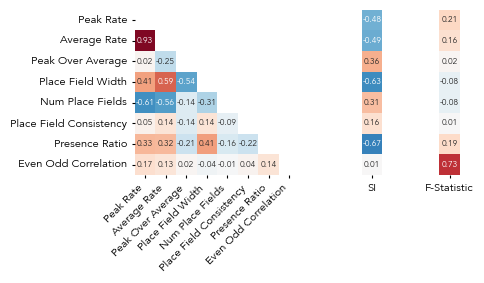

In [28]:
grid = make_grid(4, 6, wspace=0,hspace = 1,figsize=(6,3)
                 )

plt.rcParams.update(PLOT_PARAMS)

feature_labels = [name.replace('_', ' ').title() for name in feature_names]

# Feature correlation matrix
ax = get_grid_subplot(grid, slice(0, 3), slice(0, 3))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
# Create mask to hide both upper triangle and diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
sns.heatmap(correlation_matrix, mask=mask, xticklabels=feature_labels, yticklabels=feature_labels,
            cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.2f', ax=ax, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Place info correlations
ax = get_grid_subplot(grid,slice(0, 3) , 3)
place_info_corr = [correlations[f'{feat}_vs_place_info'] for feat in feature_names]
sns.heatmap(np.array(place_info_corr).reshape(-1,1), yticklabels=[], xticklabels=['SI'],
            cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.2f', ax=ax, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(),  ha='center')

# Place ANOVA correlations
ax = get_grid_subplot(grid,slice(0, 3) , 4)
place_anova_corr = [correlations[f'{feat}_vs_place_anova'] for feat in feature_names]
sns.heatmap(np.array(place_anova_corr).reshape(-1,1), yticklabels=[], xticklabels=['F-Statistic'],
            cmap='RdBu_r', vmin=-1, vmax=1,  square=True, annot=True, fmt='.2f', ax=ax, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(), ha='center')